In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

## Objectives:
- Develop the best strategy to book Airb&b rooms in Boston
    - Find the cheapest/most expensive listings in the same area (zipcode) at similar rating levels

## Load in Data

In [2]:
lst_df = pd.read_csv('data/boston/listings.csv')
cal_df = pd.read_csv('data/boston/calendar.csv')
rev_df = pd.read_csv('data/boston/reviews.csv')

### Take a quick look at the data

In [3]:
display(lst_df.shape, cal_df.shape, rev_df.shape)

(3585, 95)

(1308890, 4)

(68275, 6)

In [4]:
lst_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [5]:
cal_df.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In [6]:
rev_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


44 out of the 95 columns in the `listing` table have NAN values

In [7]:
(lst_df.isna().mean() > 0).value_counts()

False    51
True     44
dtype: int64

In [8]:
# Columns with the most missing values

lst_df.isna().mean().sort_values(ascending = False).head(50)

neighbourhood_group_cleansed    1.000000
jurisdiction_names              1.000000
license                         1.000000
has_availability                1.000000
square_feet                     0.984379
monthly_price                   0.752301
weekly_price                    0.751185
security_deposit                0.625662
notes                           0.550907
interaction                     0.433473
access                          0.415342
neighborhood_overview           0.394700
host_about                      0.365132
transit                         0.359833
house_rules                     0.332497
cleaning_fee                    0.308787
space                           0.294840
review_scores_accuracy          0.229568
review_scores_location          0.229289
review_scores_value             0.229010
review_scores_checkin           0.228731
review_scores_cleanliness       0.228173
review_scores_communication     0.228173
review_scores_rating            0.226778
reviews_per_mont

In [9]:
# Columns contain keywords "review"

lst_df.filter(like = 'score', axis = 1).isna().mean()

review_scores_rating           0.226778
review_scores_accuracy         0.229568
review_scores_cleanliness      0.228173
review_scores_checkin          0.228731
review_scores_communication    0.228173
review_scores_location         0.229289
review_scores_value            0.229010
dtype: float64

In [10]:
lst_df.select_dtypes(exclude = 'object').columns

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'square_feet', 'guests_included', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'jurisdiction_names',
       'calculated_host_listings_count', 'reviews_per_month'],
      dtype='object')

In [11]:
lst_df['id'].is_unique

True

In [12]:
lst_df.select_dtypes(include = 'object').columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed', 'city', 'state',
       'zipcode', 'market', 'smart_location', 'country_code', 'country',
       'is_location_exact', 'property_type', 'room_type', 'bed_type',
       'amenities', 'price', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'extra_people', 'calendar_updated',
       'calendar_last_scraped', 'first_rev

In [62]:
# cut the review_scores_rating into 10 bins
bins = list(range(0,110,10))
lst_df['ratings']=pd.cut(lst_df['review_scores_rating'],bins)

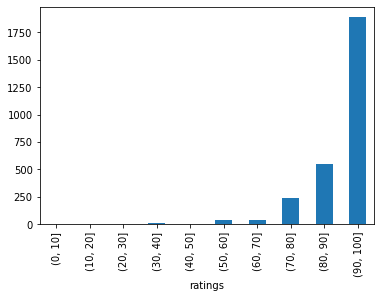

In [63]:
# How many listings fall under each rating
lst_df.groupby('ratings').count()['id'].plot(kind = 'bar')

### Is higher rated listing more expensive?

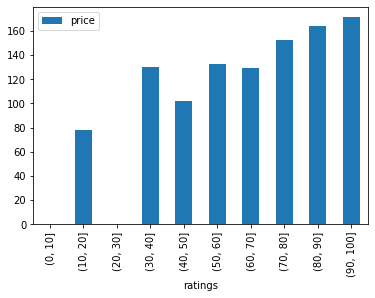

In [64]:
# convert price column data type from object to float
lst_df['price'] = lst_df['price'].replace('[\$,]', '', regex=True).astype(float)

# plot average listing price against review scores
lst_df.groupby('ratings')[['price']].mean().plot(kind = 'bar')


### How does host response time impact customer satisfaction?

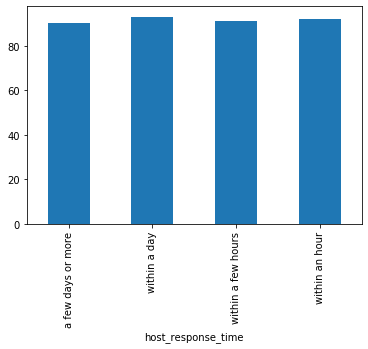

In [67]:
lst_df.groupby('host_response_time').mean()['review_scores_rating'].plot.bar()

### Most expensive zipcode

In [79]:
lst_df.groupby(['zipcode'])['price'].agg(['mean','count']).sort_values('mean', ascending = False)

,mean,count
zipcode,,
02108 02111,334.000000,1
02210,313.440000,75
02110,274.076923,13
02142,270.000000,1
02111,253.535354,99
02109,238.941176,51
02108,230.361111,72
02116,229.180412,388
02215,225.546610,236


### Does super host's room command a premium

In [84]:
lst_df.groupby(['host_is_superhost'])['review_scores_rating'].agg(['mean','count']).sort_values('mean', ascending = False)

,mean,count
host_is_superhost,,
t,97.076142,394
f,91.061817,2378


In [85]:
lst_df.groupby(['host_is_superhost'])['price'].agg(['mean','count']).sort_values('mean', ascending = False)

,mean,count
host_is_superhost,,
t,176.434889,407
f,173.604468,3178
